In [5]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\dataset.pkl', map_location=device)

In [91]:
# Get the first graph in the dataset
data = dataset[59].clone()

In [92]:
#data = dataset[10].clone()

In [ ]:
data

In [ ]:
data.behaviour_names

In [ ]:
data.frame_mask

In [96]:
node_features = data.x
edge_index = data.edge_index
frame_mask = data.frame_mask

In [97]:
def is_undirected(edge_index):
    # Sort the edges to ensure each pair (u, v) and (v, u) is in the same order.
    sorted_edges = edge_index.t().sort(dim=1)[0]
    
    # Find unique edges and count their occurrences.
    unique_edges, counts = torch.unique(sorted_edges, dim=0, return_counts=True)
    
    # For the graph to be undirected, each unique edge should appear twice.
    return torch.all(counts == 2), unique_edges, counts

flag, unique_edges, counts = is_undirected(edge_index)



In [ ]:
print(counts.unique())

In [ ]:
# print the edges that have other than 2 counts and their counts
print(len(unique_edges[counts == 2]))

In [100]:
edge_index = edge_index.numpy()

In [ ]:
# Plot the graph
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G1 = nx.Graph()
G.add_nodes_from(range(node_features.shape[0]))
G1.add_nodes_from(range(node_features.shape[0]))
edge_color = []
edge1_color = []
edges = []
for edge in edge_index.T:
    #if node_features[edge[0], 4] != node_features[edge[1], 4]:
    if frame_mask[edge[0]] != frame_mask[edge[1]]:
        G1.add_edge(edge[0], edge[1], color='y')
        edges.append((edge[0], edge[1]))
        edge1_color.append('y')
        print('r')
    else:
        edges.append((edge[0], edge[1]))
        G.add_edge(edge[0], edge[1], color='k')
        edge_color.append('k')

#G.add_edges_from(edge_index.T.tolist())

In [ ]:
G.nodes

In [ ]:
node_features[:,3]

In [ ]:
data.frame_mask

In [105]:
# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
# Put different colors to the nodes depending on the node features
colors = node_features[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'b' for c in colors]

# Node sizes
size = 100
# alpha of the edges
alpha = 0.3
# Position of the nodes
pos = node_features[:, :2].numpy()
# Add data.frame_mask to the x coordinate
# Frame difference
frame_x_diff = data.frame_mask.numpy().copy()
# Normalize the frame difference
frame_x_diff = ((frame_x_diff - frame_x_diff.min())*2) / (frame_x_diff.max() - frame_x_diff.min())
pos[:, 0] += frame_x_diff


In [ ]:
frame_x_diff

In [ ]:
pos

In [ ]:
# count values of data.frame_mask.numpy()
unique, counts = np.unique(data.frame_mask.numpy(), return_counts=True)
dict(zip(unique, counts))


In [ ]:
# Plot the graph
plt.figure(figsize=(25, 8))

# Draw edges with different colors and alpha values
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_color, width=2)
nx.draw_networkx_edges(G1, pos, alpha=0.5, edge_color=edge1_color, width=2, style='dashed')

# Draw nodes with different colors and sizes
node_sizes = [size if color == 'r' else size for color in colors]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, edgecolors='k', linewidths=0.5)

# Add legend for the nodes
plt.scatter([], [], c='r', label='Individual 1', s=100, edgecolors='k')
plt.scatter([], [], c='b', label='Individual 2', s=100, edgecolors='k')

# Add legend for the edges
plt.plot([], [], c='k', label='Spatial edges (same frame)', linewidth=2)
plt.plot([], [], c='y', label='Temporal edges (different frame)', linewidth=2, linestyle='dashed')

# Plot a discrete x-axis to show the frames
centers = np.arange(pos[:, 0].min() - 0.1, pos[:, 0].max() + 0.1, (pos[:, 0].max() - pos[:, 0].min() + 0.2) / 5)
frames = ['Frame: -2', 'Frame: -1', 'Frame: 0', 'Frame: 1', 'Frame: 2']

num_frames = 5
for i in range(num_frames):
    plt.text(centers[i] + 0.2, pos[:, 1].min() - 0.1, frames[i], fontsize=12, fontweight='bold', color='darkblue')
    plt.plot([centers[i], centers[i]], [pos[:, 1].min() - 0.1, pos[:, 1].max() + 0.1], 'k--')

# Indicate the frame number
plt.xlabel('Frame number', fontsize=14, fontweight='bold')
plt.ylabel('Y Coordinate', fontsize=14, fontweight='bold')

# Center the x-axis
plt.legend(loc='upper right', fontsize=12)
plt.title('Spatio-Temporal Graph of Pose-Estimated Mice', fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Lets only plot the nodes that are in a same frame
nodes_features_to_keep = node_features[node_features[:,4]==0]

In [ ]:
nodes_features_to_keep.shape

In [820]:
# edge_index of the nodes that are in the same frame
G = nx.Graph()

# Get the indices of the nodes that are in the same frame
nodes_in_frame = np.where(node_features[:,4]==0)[0]
nodes_features_to_keep = node_features[node_features[:,4]==0]

G.add_nodes_from(nodes_in_frame)

edge_index = edge_index.numpy()

# Keep only the edges that are between nodes in the same frame
for i in range(edge_index.shape[1]):
    if edge_index[0, i] in nodes_in_frame and edge_index[1, i]in nodes_in_frame:
        G.add_edge(edge_index[0, i], edge_index[1, i])



In [ ]:
G.number_of_nodes()

In [ ]:
G.edges

In [ ]:
nodes_in_frame

In [ ]:
edge_index

In [ ]:
G.nodes

In [ ]:
edge_index[0, 0]
edge_index[1, 0]

In [ ]:
nodes_features_to_keep[:,:2].numpy()

In [ ]:


# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
pos = node_features[:, :2].numpy()
# mappi
colors = nodes_features_to_keep[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'y' for c in colors]

# Plot
plt.figure(figsize=(25, 8))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()



## Just Loading a model

In [44]:
import torch
import importlib

In [45]:
# Load the model
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return model, optimizer, epoch

In [ ]:
checkpoint = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\runs\new_encoder_no_linearResCon\Dominance_R\checkpoint_epoch_190.pth', map_location='cpu')

In [ ]:
checkpoint['epoch']

In [ ]:
import models
importlib.reload(models)

In [41]:
graphencoder = models.GATEncoder_vfollowing(8, 16, 2, 4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=576, nhid = 32, nout = 2)

In [42]:
readout = 'concatenate'
model = models.GraphClassifier(graphencoder, class_head, readout= readout)

In [ ]:
for key in checkpoint['model_state_dict']:
    print(key, checkpoint['model_state_dict'][key].shape)

In [ ]:
# Print shapes of the model
for name, param in model.named_parameters():
    print(name, param.shape)

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# count parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

---

---

# Visualization of validation accuracy per epoch.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [71]:
path = r'c:\Users\jalvarez\Documents\Experiments\new_encoder_no_linearResCon\Sniffing_R\Oct20_13-10-57\csv.csv'

df = pd.read_csv(path)
df

,Wall time,Step,Value
0,1.728986e+09,0,0.723876
1,1.728987e+09,1,0.782000
2,1.728987e+09,2,0.809950
3,1.728987e+09,3,0.811458
4,1.728988e+09,4,0.813109
...,...,...,...
595,1.729489e+09,595,0.884492
596,1.729489e+09,596,0.884411
597,1.729489e+09,597,0.885516
598,1.729490e+09,598,0.884103


In [72]:
# Drop column 'Wall time'
df = df.drop(columns=['Wall time'])

In [73]:
# Drop the index
df = df.reset_index(drop=True)
df

,Step,Value
0,0,0.723876
1,1,0.782000
2,2,0.809950
3,3,0.811458
4,4,0.813109
...,...,...
595,595,0.884492
596,596,0.884411
597,597,0.885516
598,598,0.884103


In [75]:
# Drop the index
df = df.reset_index(drop=True)
df

,Step,Value
0,0,0.723876
1,1,0.782000
2,2,0.809950
3,3,0.811458
4,4,0.813109
...,...,...
595,595,0.884492
596,596,0.884411
597,597,0.885516
598,598,0.884103


In [80]:
steps = df['Step']
values = df['Value']

In [81]:
# keep only each 10 epochs
steps = steps[::10]
values = values[::10]


In [82]:
steps

0        0
10      10
20      20
30      30
40      40
50      50
60      60
70      70
80      80
90      90
100    100
110    110
120    120
130    130
140    140
150    150
160    160
170    170
180    180
190    190
200    200
210    210
220    220
230    230
240    240
250    250
260    260
270    270
280    280
290    290
300    300
310    310
320    320
330    330
340    340
350    350
360    360
370    370
380    380
390    390
400    400
410    410
420    420
430    430
440    440
450    450
460    460
470    470
480    480
490    490
500    500
510    510
520    520
530    530
540    540
550    550
560    560
570    570
580    580
590    590
Name: Step, dtype: int64

In [79]:
steps = steps[:-3]
values = values[:-3]

In [83]:
import seaborn as sns



In [84]:
max_value = values.max()
max_step = steps[values.idxmax()]

print(f"Max value: {max_value} at step {max_step}")

Max value: 0.8848994970321655 at step 570


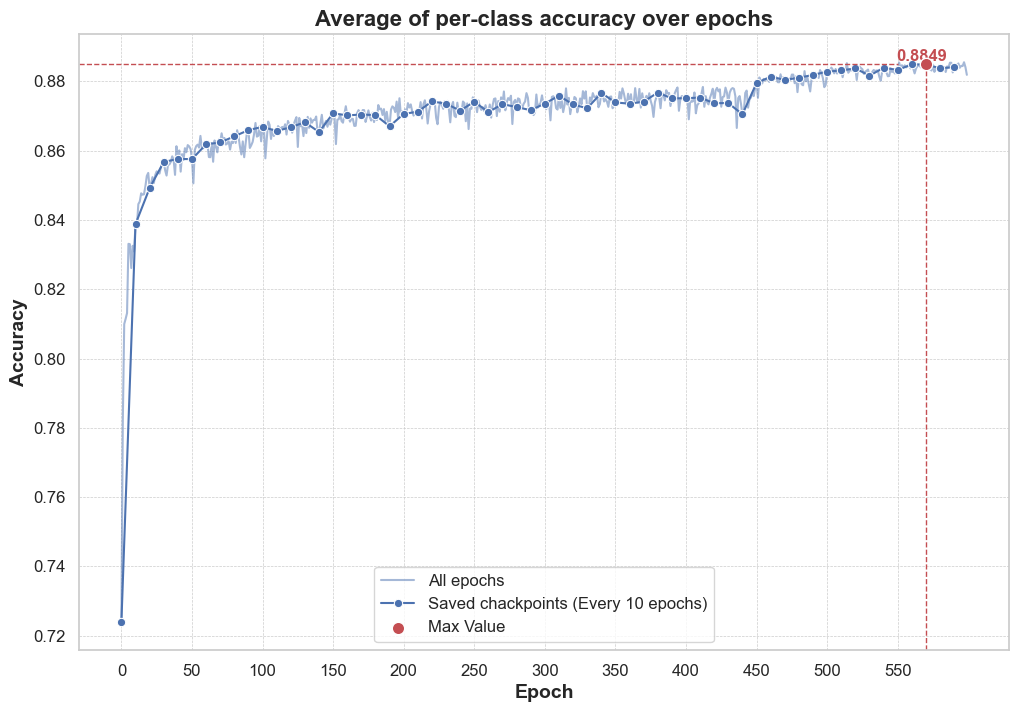

In [85]:
# Set the style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(df['Step'], df['Value'], alpha = 0.5, label = 'All epochs')
sns.lineplot(x=steps, y=values, marker='o', color='b', label = 'Saved chackpoints (Every 10 epochs)')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Average of per-class accuracy over epochs', fontsize=16, fontweight='bold')

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# The reference in the x axis each 10 epochs
plt.xticks(steps[::5])


# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Trace lines on the max value
plt.axvline(x=max_step, color='r', ymax=0.95, linestyle='--', linewidth=1)
plt.axhline(y=max_value, color='r', xmax=0.88, linestyle='--', linewidth=1)

# Plot to 200 epochs
#plt.xlim(0, 200)
# Indicate the max value
plt.text(max_step+15, max_value+0.001, f'{max_value:.4f}', color='r', fontsize=12, fontweight='bold', ha='right')

# Add a marker for the max value
plt.scatter(max_step, max_value, color='r', s=80, zorder=5, edgecolors='w', label='Max Value')

plt.legend(fontsize=12)
# Show the plot
plt.show()


---
---

# Confussion martices for GAT models

In [1]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader, DataListLoader
import tqdm
import time
import augmentation
import sklearn

In [ ]:
importlib.reload(augmentation)

In [1]:
# Import f1_score and matthews_corrcoef from sklearn
from sklearn.metrics import f1_score, matthews_corrcoef


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pickle as pkl

In [2]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()



NameError: name 'torch' is not defined

In [ ]:
del dataset

In [ ]:
# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\datasets\dataset_5.pkl', map_location=device)

#Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
    #    'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
    #    'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
    #    'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
    #    'Grooming_V'],
    #   dtype='object')
# Select the behaviour to classify (Grooming in this case)
indx_behaviour1 = 3
indx_behaviour2 = 11

In [ ]:
# Select the behaviour to classify
name_behaviour = dataset[0].behaviour_names[indx_behaviour1]
print(f"Behaviour selected: {name_behaviour}")

# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)

# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]


In [ ]:
print('Merging the behaviours')
augmentation.merge_symetric_behaviours_version2(indx_behaviour1, indx_behaviour2, train_dataset, device=device)
print('Generating rotation augmentation')
# Rotate the dataset
augmentation.rotate_samples(train_dataset, indx_behaviour1, device=device)
#print('Downsampling the inactive behaviours')
#train_dataset = augmentation.downsample_majority_class(train_dataset, indx_behaviour1)

In [ ]:
for i in range(len(test_dataset)):
    test_dataset[i].behaviour = test_dataset[i].behaviour[indx_behaviour1]
for i in range(len(train_dataset)):
    train_dataset[i].behaviour = train_dataset[i].behaviour[indx_behaviour1]
print('Done selecting the behaviour')

print('The test dataset has %d samples' % len(test_dataset))
print('The train dataset has %d samples' % len(train_dataset))


In [11]:
# class balance
behaviour = [data.behaviour.item() for data in train_dataset]


In [ ]:
# Class balance
unique, counts = np.unique(behaviour, return_counts=True)

dict(zip(unique, counts))

In [ ]:
batch_size = 64

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [176]:
graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_heads = 2, n_in = 4, n_layers=4, dropout=0.2)
class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)

readout = 'mean'
model = models.GraphClassifier(graphencoder, class_head, readout=readout)

In [177]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
metric_0 = f1_score
metric_1 = matthews_corrcoef


In [178]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return epoch


In [ ]:
checkpoint_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Checkpoints\new_encoder_no_linearResCon\Sniffing_R\checkpoint_epoch_150.pth'
actual_epoch = load_checkpoint(model, optimizer, checkpoint_path)

In [ ]:
model.eval()
val_loss = 0
correct = 0
correct_class_0 = 0
correct_class_1 = 0
total_class_0 = 0
total_class_1 = 0
total = 0
with torch.no_grad():
    for val_data in tqdm.tqdm(test_loader):
        val_outputs = model(val_data)
        val_labels = val_data.behaviour
        val_predicted = val_outputs.argmax(dim=1)
        correct_class_0 += (val_predicted[val_labels == 0] == val_labels[val_labels == 0]).sum().item()
        correct_class_1 += (val_predicted[val_labels == 1] == val_labels[val_labels == 1]).sum().item()
        total_class_0 += (val_labels == 0).sum().item()
        total_class_1 += (val_labels == 1).sum().item()
        correct += (val_predicted == val_labels).sum().item()
        total += val_labels.size(0)

In [ ]:
val_accuracy = correct / total
print(f'Accuracy of the network on the test set: {100 * val_accuracy:.2f}%')

val_accuracy_class_0 = correct_class_0 / total_class_0
val_accuracy_class_1 = correct_class_1 / total_class_1
print(f'Accuracy of the network on the test set for class 0: {100 * val_accuracy_class_0:.2f}%')
print(f'Accuracy of the network on the test set for class 1: {100 * val_accuracy_class_1:.2f}%')

avg_val_accuracy = (val_accuracy_class_0 + val_accuracy_class_1) / 2
print(f'Average accuracy of the network on the test set: {100 * avg_val_accuracy:.2f}%')


In [ ]:
# Build the confusion matrix
cm = np.array([[


In [162]:

val_labels = torch.cat(val_labels, dim=0).cpu().numpy()
val_preds = torch.cat(val_preds, dim=0).cpu().numpy()


In [ ]:
len(val_labels)
len(val_preds)

In [ ]:
# Compute the metrics
f1_class_0 = metric_0(val_labels, val_preds, average='macro')
mcc = metric_1(val_labels, val_preds)

print(f'F1 Score (Class 0): {f1_class_0:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')


In [164]:
# Confusion matrix
cm= sklearn.metrics.confusion_matrix(val_labels, val_preds)


In [ ]:
cm

In [ ]:
i

In [2]:
import pickle as pkl

In [ ]:
# Loqd pkl file

path = r'c:\Users\Usuario\Downloads\results_epoch_150.pkl'

with open(path, 'rb') as f:
    metrics = pkl.load(f)

metrics


In [ ]:


cm = np.array([[metrics['correct_class_0'], metrics['total_class_0'] - metrics['correct_class_0']], [metrics['total_class_1'] - metrics['correct_class_1'], metrics['correct_class_1']]])

cm

In [8]:
# Normalize the confusion matrix

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt = '.2f', annot_kws={"size": 12}, cmap='Blues', cbar=False, linewidths=0.5, linecolor='k')
             

# Add labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('True', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Customize the ticks
plt.xticks([0.5, 1.5], ['Class 0', 'Class 1'], fontsize=12)
plt.yticks([0.5, 1.5], ['Class 0', 'Class 1'], fontsize=12)

# Show the plot
plt.show()


---
---

# Classes Balances

In [ ]:
# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\datasets\dataset_5.pkl', map_location=device)


In [ ]:
# Select behaviour
behaviour_idx = 0


print(dataset[0].behaviour_names[behaviour_idx])

label = []
for i in range(len(dataset)):
    label.append(dataset[i].behaviour[behaviour_idx])

In [ ]:
# Balance
unique, counts = np.unique(label, return_counts=True)
print('Unique labels:', unique)
print('Counts:', counts)

print("The percentage of the minority class is: ", counts[1] / counts.sum())

---
---

In [6]:
path = r'c:\Users\jalvarez\Documents\Experiments\checkpoint_epoch_190.pth'

# Load the model
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return epoch



In [7]:
# Define the model
#graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_hidden=2, n_in=4, dropout=0.5)
#class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)
# Define the model
graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_heads = 2, n_in = 4, n_layers=4, dropout=0.2)
class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)

readout = 'mean'
model = models.GraphClassifier(graphencoder, class_head, readout= readout)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# load the checkpoint
load_checkpoint(model, optimizer, path, device = 'cpu')


Checkpoint loaded from c:\Users\jalvarez\Documents\Experiments\checkpoint_epoch_190.pth, at epoch 30


30

---
---

In [97]:
path = r'c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST'
device = 'cpu'
data = dataloader.DLCDataLoader(path, load_dataset=True)

dataset = data.data_list

Dataset loaded from c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST\dataset.pkl


In [98]:
data0 = dataset[0]

In [99]:
data0.x[:,3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [100]:
# Swap identities



In [101]:
def swap_identities(dataset):
    """
    Swap the identities of the resident in the dataset. This is used to analyze the behaviour of the visitor when doing inference.

    Parameters:
        dataset list of torch.geometric.data.Data: The dataset to swap the identities of the resident.
    """

    for data in dataset:
        data.x[:, 3] = 1 - data.x[:, 3]

swap_identities(dataset)

In [102]:
data0 = dataset[0]
data0.x[:,3]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])